In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import shutil
import os
import zipfile
from sklearn import metrics
from sklearn.metrics import classification_report
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
# from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras import layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
# random select 15 birds - discrimination is wrong so we picked 15 birds at random

def get_random_folders(num_folders):
    test_folder_path = "data/test.zip"
    with zipfile.ZipFile(test_folder_path, 'r') as zip_ref:
        file_names = [name for name in zip_ref.namelist() if not name.endswith('/')] 
        if not file_names:
            raise ValueError("Thank")
        folder_names = list(set([os.path.dirname(name) for name in file_names])) 
        if not folder_names:
            raise ValueError("You")
        random_folders = random.sample(folder_names, min(num_folders, len(folder_names)))
        random_folders = [folder_name.split('/')[0] for folder_name in random_folders] 
    return random_folders

In [5]:
# birds = get_random_folders(510) # select number of birds or take all 510
# len(set(birds))

# birds = get_random_folders(15)
# birds

['SCARLET IBIS',
 'ROSE BREASTED GROSBEAK',
 'BLACK-THROATED SPARROW',
 'BANANAQUIT',
 'DEMOISELLE CRANE',
 'KING EIDER',
 'MARABOU STORK',
 'GYRFALCON',
 'CLARKS NUTCRACKER',
 'HIMALAYAN BLUETAIL',
 'INLAND DOTTEREL',
 'BORNEAN PHEASANT',
 'RED SHOULDERED HAWK',
 'PHILIPPINE EAGLE',
 'AMERICAN BITTERN']

In [11]:
# removes old folders - otherwise it would add birds to existing train/test/valid folders that already have birds

data_dir = 'data'
folders_to_remove = ['test', 'train', 'valid']

for folder in folders_to_remove:
    folder_path = os.path.join(data_dir, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)


In [12]:
############## IF YOU KNOW WHICH BIRDS YOU WANT, ENTER HERE #####################
# make sure to run previous code block (removes old folders) before continuing

birds = ['SCARLET IBIS',
         'ROSE BREASTED GROSBEAK',
         'BLACK-THROATED SPARROW',
         'BANANAQUIT',
         'DEMOISELLE CRANE',
         'KING EIDER',
         'MARABOU STORK',
         'GYRFALCON',
         'CLARKS NUTCRACKER',
         'HIMALAYAN BLUETAIL',
         'INLAND DOTTEREL',
         'BORNEAN PHEASANT',
         'RED SHOULDERED HAWK',
         'PHILIPPINE EAGLE',
         'AMERICAN BITTERN']



In [13]:
# creates new train/test/valid folders with selected birds from above

zip_dir = 'data'

for zip_file in ['train.zip', 'test.zip', 'valid.zip']:
    with zipfile.ZipFile(os.path.join(zip_dir, zip_file), 'r') as zip_ref:
        for bird in birds:
            zip_ref.extractall(path=os.path.join(zip_dir, zip_file.split('.')[0]), members=[member for member in zip_ref.namelist() if bird in member and not os.path.isdir(os.path.join(zip_dir, zip_file.split('.')[0], member))])

In [9]:
train_dir = os.path.join(zip_dir, 'train')
test_dir = os.path.join(zip_dir, 'test')
valid_dir = os.path.join(zip_dir, 'valid')

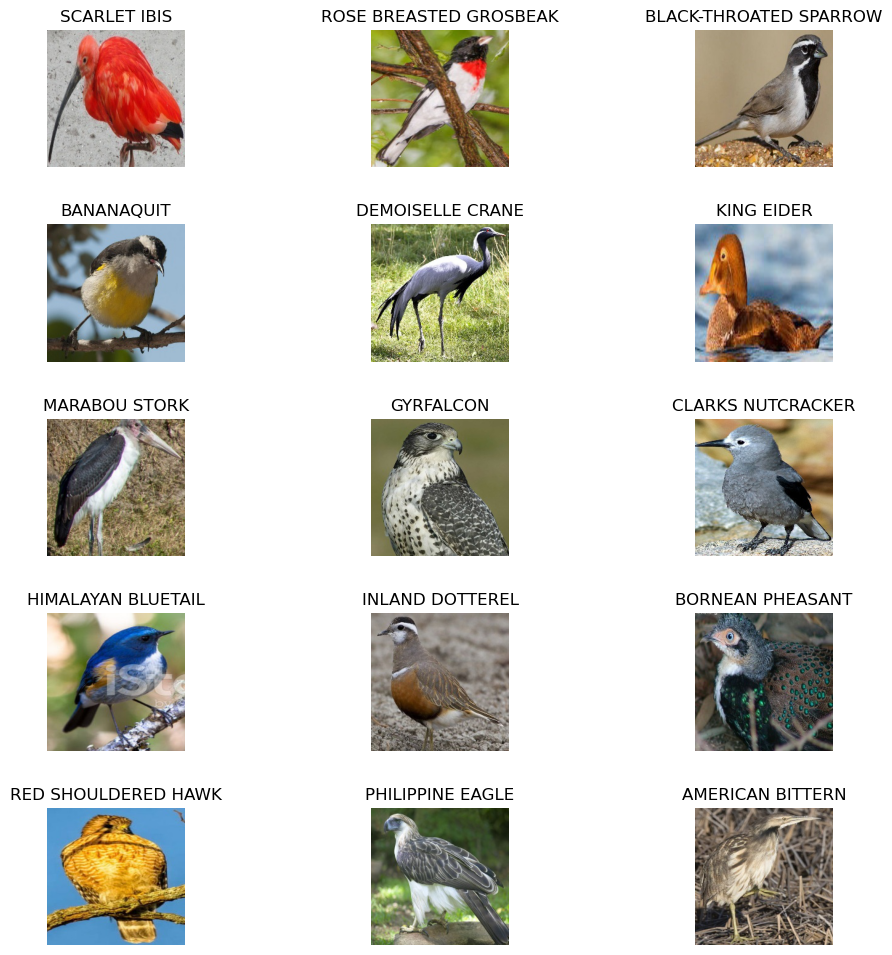

In [10]:
# images and names

fig, axs = plt.subplots(5, 3, figsize=(10, 10)) # update if you select more than 15 birds
plt.tight_layout(pad=2)

for i, bird in enumerate(birds):
    bird_dir = os.path.join(train_dir, bird)
    img_path = os.path.join(bird_dir, os.listdir(bird_dir)[0])
    img = plt.imread(img_path)
    row, col = divmod(i, 3)
    axs[row, col].imshow(img)
    axs[row, col].set_title(bird)
    axs[row, col].axis("off")
    
plt.show()

In [8]:
batch_size = 15
original_size = (150, 150) # original size = 224x224

In [12]:
######################## RUN FROM HERE IF YOU WISH TO KEEP THE SAME SET OF 15 BIRDS ############################

In [13]:
tf.keras.backend.clear_session() # allows for the enviroment to be less slow

# basic preprocessing 

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(original_size),
    batch_size=batch_size,
    label_mode='categorical',
    seed=1,
    crop_to_aspect_ratio=True
    )

valid_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=(original_size),
    batch_size=batch_size,
    label_mode='categorical',
    seed=1,
    crop_to_aspect_ratio=True)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(original_size),
    batch_size=batch_size,
    label_mode='categorical',
    seed=1,
    shuffle=False, # do NOT remove - need for predictions
    crop_to_aspect_ratio=True)

Found 2438 files belonging to 15 classes.
Found 75 files belonging to 15 classes.
Found 75 files belonging to 15 classes.


2023-03-27 08:14:00.430215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# augmentation

data_augmentation = keras.Sequential([
    keras.layers.Resizing(*original_size, interpolation='mitchellcubic'),
    keras.layers.RandomFlip("horizontal",seed=1),
    keras.layers.RandomZoom(0.2,seed=1),
])

train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label), 
    num_parallel_calls=tf.data.AUTOTUNE,
)

valid_dataset = valid_dataset.map(
    lambda img, label: (img, label), # should NOT do aug on val set (or test set) because we want to evaluate the model's performance on unseen data
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [15]:
# throrough random seeding for reproducibility
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

# Cable News Network model
# batch normalization, regularization, dropouts, etc, to improve performance, avoid overfitting, etc

num_classes = 15

model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(*original_size, 3)),
    keras.layers.Conv2D(64, 7, padding='same', strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(128, 5, padding='same', strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(256, 5, padding='same', strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.75),
    
    keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 128)      

In [16]:
# learning rate scheduler to decrease lr over time to converge more smoothly and not overfit

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-10) # because that's my patience level on a scale from 1-100  (but it ends up taking longer lol)

In [17]:
# train stopping - early stopping if val_loss hasn't improve over n epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['categorical_accuracy'])
# used categorical accuracy (instead of accuracy) for evaluating classification performance

In [19]:
history = model.fit(x=train_dataset, validation_data=valid_dataset, epochs=70, callbacks=[reduce_lr, early_stopping])

Epoch 1/70
163/163 [==============================] - 32s 181ms/step - loss: 7.6364 - categorical_accuracy: 0.1288 - val_loss: 6.3610 - val_categorical_accuracy: 0.1867 - lr: 0.0010
Epoch 2/70
163/163 [==============================] - 30s 183ms/step - loss: 5.3107 - categorical_accuracy: 0.2605 - val_loss: 4.5044 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/70
163/163 [==============================] - 31s 188ms/step - loss: 4.0331 - categorical_accuracy: 0.3376 - val_loss: 3.3009 - val_categorical_accuracy: 0.5733 - lr: 0.0010
Epoch 4/70
163/163 [==============================] - 30s 181ms/step - loss: 3.2680 - categorical_accuracy: 0.4003 - val_loss: 3.4916 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 5/70
163/163 [==============================] - 29s 179ms/step - loss: 2.8861 - categorical_accuracy: 0.4303 - val_loss: 2.6229 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 6/70
163/163 [==============================] - 31s 188ms/step - loss: 2.5805 - cate

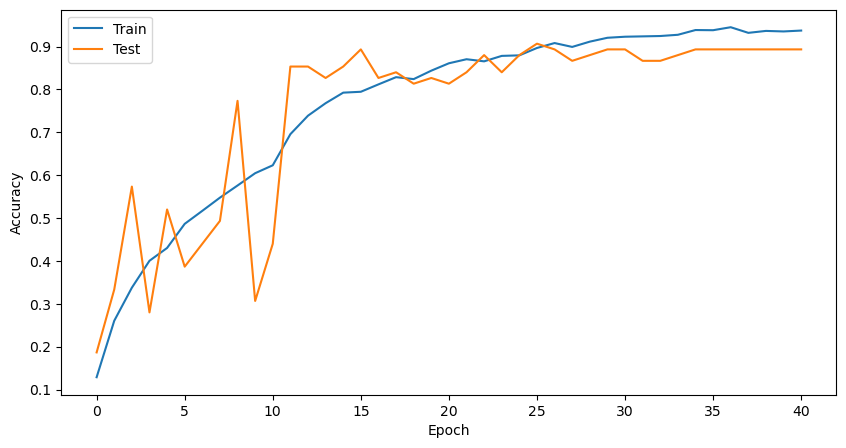

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
model.evaluate(test_dataset)

5/5 [==============================] - 0s 50ms/step - loss: 0.5111 - categorical_accuracy: 0.9467


[0.5110712051391602, 0.9466666579246521]

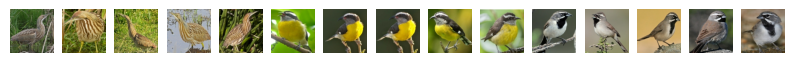

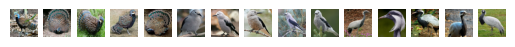

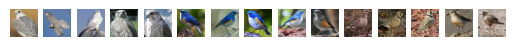

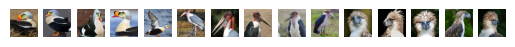

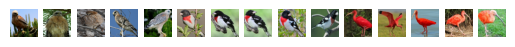

In [24]:
# test set images split into batches zoomed in on first batch

plt.figure(figsize=(10, 10))
class_names = test_dataset.class_names
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        ax = plt.subplot(5, 15, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

5/5 [==============================] - 0s 48ms/step


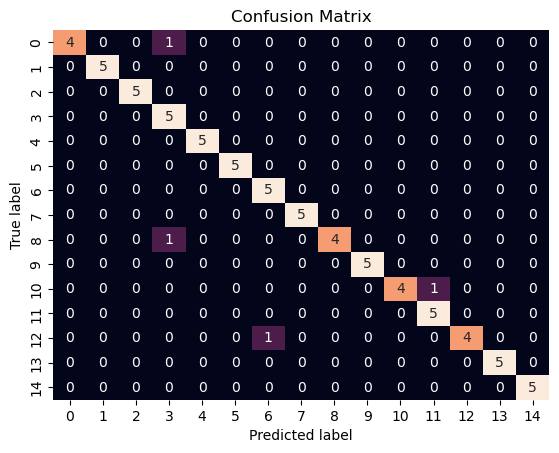

In [25]:
# confusion matrix

y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0) 
y_true = np.argmax(y_true, axis=1)

sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# classification report

print(classification_report(y_true, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

      AMERICAN BITTERN       1.00      0.80      0.89         5
            BANANAQUIT       1.00      1.00      1.00         5
BLACK-THROATED SPARROW       1.00      1.00      1.00         5
      BORNEAN PHEASANT       0.71      1.00      0.83         5
     CLARKS NUTCRACKER       1.00      1.00      1.00         5
      DEMOISELLE CRANE       1.00      1.00      1.00         5
             GYRFALCON       0.83      1.00      0.91         5
    HIMALAYAN BLUETAIL       1.00      1.00      1.00         5
       INLAND DOTTEREL       1.00      0.80      0.89         5
            KING EIDER       1.00      1.00      1.00         5
         MARABOU STORK       1.00      0.80      0.89         5
      PHILIPPINE EAGLE       0.83      1.00      0.91         5
   RED SHOULDERED HAWK       1.00      0.80      0.89         5
ROSE BREASTED GROSBEAK       1.00      1.00      1.00         5
          SCARLET IBIS       1.00      

In [27]:
#save the model
model.save('saved_models/my_model.h5')

In [3]:
# load the model
reconstructed_model = keras.models.load_model('saved_models/my_model.h5')

# display the summary of the loaded model
reconstructed_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 128)      

In [14]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(original_size),
    batch_size=batch_size,
    label_mode='categorical',
    seed=1,
    shuffle=False, # do NOT remove - need for predictions
    crop_to_aspect_ratio=True)

Found 75 files belonging to 15 classes.


In [15]:
reconstructed_model.evaluate(test_dataset)

5/5 [==============================] - 0s 62ms/step - loss: 0.5111 - categorical_accuracy: 0.9467


[0.5110712051391602, 0.9466666579246521]

## Relevant Links

https://keras.io/examples/vision/image_classification_from_scratch/

https://keras.io/api/layers/constraints/

https://www.tensorflow.org/tutorials/images/classification

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
################# WAYS TO INCREASE ACCURACY ##########################################################################

# INCREASE EPOCHS AND/OR DECREASE BATCH SIZE

# REGULARIZE WITH L2 OR DROPOUT

# DATA AUGMENTATION

# OPTIMZER AND LEARNING RATE

# ADD MORE LAYERS OR INCREASE NUMBER OF NEURONS

In [ ]:
# COULD INCLUDE CROSS VALIDATION SO IT FURTHER INCREASES PERFORMANCE ON UNSEEN DATA